In [1]:
# Imoportar liberias 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import OPTICS, KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.feature_selection import VarianceThreshold

In [2]:
# Cargar datos

df_csv = pd.read_csv(r"C:/Users/irwin/Downloads/Sin_GZ.csv")
df_csv
print("Datos cargados con éxito. Dimensiones:", df_csv.shape)
print(df_csv.dtypes)

Datos cargados con éxito. Dimensiones: (38, 50)
POLIZA                   object
SUBRAMO                   int64
INCISO                    int64
SINIESTRO                object
VIGENCIA                 object
TIPO DE VEHICULO         object
MARCA VEHICULO           object
DESCRIPCION VEHICULO     object
MODELO                    int64
SERIE VEHICULO           object
ESTADO                   object
POBLACIÓN                object
FECHA DE SINIESTRO        int64
AÑO                       int64
MES                      object
DÍA                      object
RANGO_HORA               object
FECHA DE REPORTE          int64
FECHA CIERRE             object
ESTATUS                  object
NOMBRE CONDUCTOR         object
TIPO PERDIDA             object
CAUSA DETALLADA          object
RESPONSABILIDAD          object
COBERTURA AFECTADA       object
CDR                      object
RED                      object
TIPO TALLER/AGENCIA     float64
RESERVA                  object
AJUSTES                 

In [3]:
df_csv['COSTO NETO TOTAL'].unique()

array(['17,280.00', '3,000.00', '0', '22,800.00', '20,419.00',
       '20,934.00', '21,511.00', '16,450.00', '6,813.50', '20,253.23',
       '9,835.39', '12,182.00', '20,967.00', '14,401.99', '39,232.00',
       '17,276.00', '22,257.00', '14,206.68', '91,327.27', '2,000.00',
       '69,828.60', '28,335.24'], dtype=object)

In [ ]:
# Limpieza y preprocesamiento de datos

for col in df_csv.columns:
    if df_csv[col].dtype == 'object':
        # Quitar símbolos comunes y convertir a número
        df_csv[col] = (
            df_csv[col]
            .astype(str)    
            .str.replace(',', '', regex=False)
            .str.replace('$', '', regex=False)
            .str.replace('%', '', regex=False)
        )
        df_csv[col] = pd.to_numeric(df_csv[col], errors='ignore')

C:\Users\irwin\AppData\Local\Temp\ipykernel_29804\2620849191.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_csv[col] = pd.to_numeric(df_csv[col], errors='ignore')
C:\Users\irwin\AppData\Local\Temp\ipykernel_29804\2620849191.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_csv[col] = pd.to_numeric(df_csv[col], errors='ignore')
C:\Users\irwin\AppData\Local\Temp\ipykernel_29804\2620849191.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_csv[col] = pd.to_numeric(df_csv[col], errors='ignore')
C:\Users\irwin\AppData\Local\Temp\ipykernel_29804\2620849191.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a 

In [7]:
# Selección de características numéricas para clustering

num_vars = df_csv.select_dtypes(include=[np.number]).columns.tolist()
print("\nVariables numéricas:", num_vars)

X = df_csv[num_vars].copy()
print("\nDimensiones de X:", X.shape)
print("\nValores nulos por columna:\n", X.isna().sum())


Variables numéricas: ['SUBRAMO', 'INCISO', 'MODELO', 'FECHA DE SINIESTRO', 'AÑO', 'FECHA DE REPORTE', 'TIPO TALLER/AGENCIA', 'RESERVA', 'AJUSTES', 'PAGO', 'DEDUCIBLE', 'RECUPERACION', 'SALVAMENTO', 'GASTOS', 'COSTO NETO TOTAL', 'RVA DISPONIBLE', 'CNS_DM', 'CNS_RT', 'CNS_GM', 'CNS_RC', 'CNS_OTROS', 'RVA_DM', 'RVA_RT', 'RVA_RC', 'RVA_GM', 'RVA_OTROS', 'CONTADOR']

Dimensiones de X: (38, 27)

Valores nulos por columna:
 SUBRAMO                 0
INCISO                  0
MODELO                  0
FECHA DE SINIESTRO      0
AÑO                     0
FECHA DE REPORTE        0
TIPO TALLER/AGENCIA    38
RESERVA                 0
AJUSTES                 0
PAGO                    0
DEDUCIBLE               0
RECUPERACION            0
SALVAMENTO              0
GASTOS                  0
COSTO NETO TOTAL        0
RVA DISPONIBLE          0
CNS_DM                  0
CNS_RT                  0
CNS_GM                  0
CNS_RC                  0
CNS_OTROS               0
RVA_DM                  0
RVA_RT

In [8]:
X.drop(columns=['TIPO TALLER/AGENCIA'], inplace=True)

In [9]:
# Eliminar 

X.dropna(inplace=True)

In [10]:
# Valores faltantes y escalamiento

imputer = SimpleImputer(strategy='mean')  # Rellena NaN con la media
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

print("\n Datos imputados y escalados. Nueva forma:", X_scaled.shape)


 Datos imputados y escalados. Nueva forma: (38, 26)


In [11]:
# OPTICS (clustering jerárquico)

opt = OPTICS(min_samples=10, xi=0.05, metric='euclidean', cluster_method='xi')
opt.fit(X_scaled)

labels_opt = opt.labels_
print("\nClústeres detectados (incluyendo ruido = -1):", np.unique(labels_opt))


Clústeres detectados (incluyendo ruido = -1): [0]


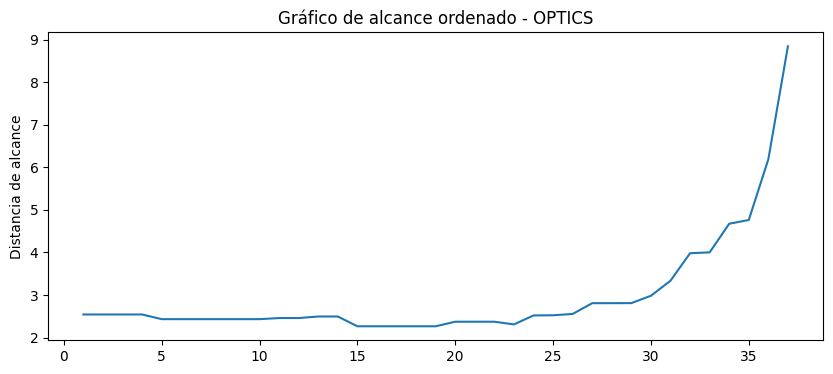

In [12]:
# Gráfico de distancia de alcance (Reachability Plot)

reach = opt.reachability_
ordering = opt.ordering_

plt.figure(figsize=(10, 4))
plt.plot(reach[ordering])
plt.ylabel('Distancia de alcance')
plt.title('Gráfico de alcance ordenado - OPTICS')
plt.show()

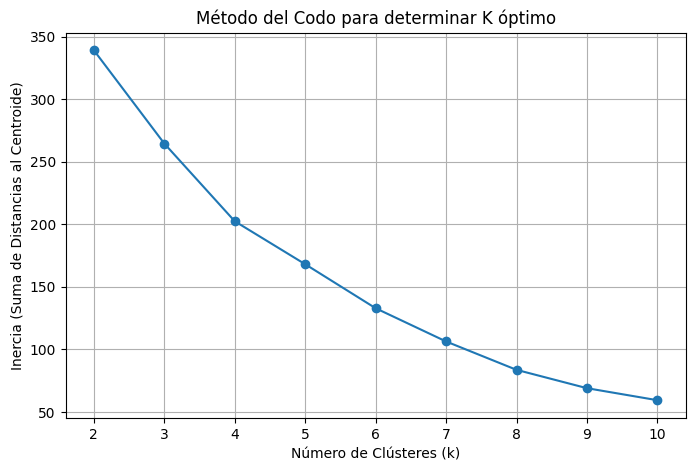

In [13]:
# K-Means (para comparar y determinar número óptimo de clústeres)

os.makedirs("figures", exist_ok=True)

inertia = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, marker='o', linestyle='-')
plt.title('Método del Codo para determinar K óptimo')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Inercia (Suma de Distancias al Centroide)')
plt.grid(True)
plt.savefig("figures/elbow.png", dpi=300, bbox_inches="tight")
plt.show()
# Evaluación de métricas de clustering para K-Means

In [14]:
# Evaluación de varianza (para detectar columnas inútiles)

selector = VarianceThreshold(threshold=0.0)
selector.fit(X)

zero_var_cols = X.columns[~selector.get_support()]
print("\nColumnas con varianza cero:", zero_var_cols.tolist())


Columnas con varianza cero: ['SUBRAMO', 'DEDUCIBLE', 'RECUPERACION', 'SALVAMENTO', 'CNS_DM', 'CNS_RT', 'CNS_GM', 'CNS_OTROS', 'RVA_DM', 'RVA_RT', 'RVA_GM', 'RVA_OTROS', 'CONTADOR']


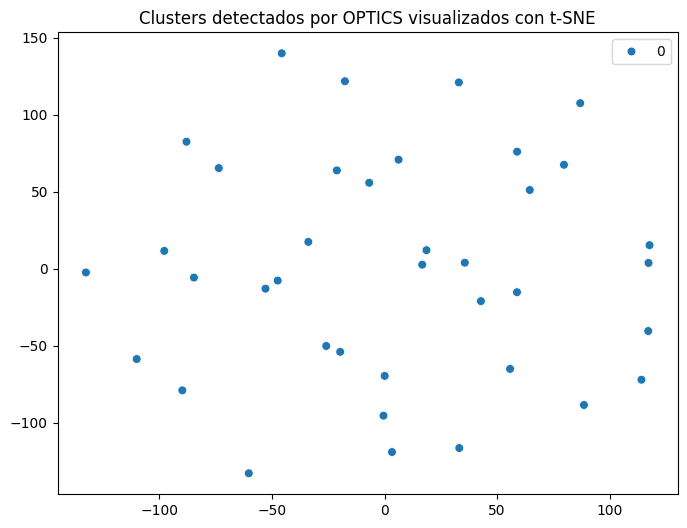

In [ ]:
#  Visualización de clústeres (t-SNE + OPTICS) #LGORITMO QUE FUNCIONE CON POCOS DATOS

tsne = TSNE(n_components=3)
X2 = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
palette = sns.color_palette('tab10', np.unique(labels_opt).size)
sns.scatterplot(
    x=X2[:, 0], Sy=X2[:, 1],
    hue=labels_opt.astype(str),
    palette=palette,
    legend='full', s=40
)
plt.title('Clusters detectados por OPTICS visualizados con t-SNE')
plt.show()